# インポートモジュール

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# 1.まず指数分布について

## 指数分布のクラスを作る

指数分布の確率密度関数は、
$$
f(x) = \lambda exp(-\lambda x)
$$

であり、N個のサンプルの対数尤度関数は、
$$
\begin{align}
l(\lambda|x) &= \sum_{i = 1}^{N}\log(\lambda exp(-\lambda x_i)) \\
&=n\log\lambda - \lambda \sum_{i = 1}^{N}x_j
\end{align}
$$

よって最尤推定量は、
$$
\hat{\lambda}^{MLE} = \frac{N}{\sum_{i = 1}^{N}x_i}
$$

In [15]:
class ExpDistribution:
    def __init__(self):
        self.param_la = 1
    
    # DensityFunction
    def PDF(self,x):
        return self.param_la * np.exp(-1 * self.param_la * x)
    
    # MaximumLikelihoodEstimation
    def MLEfit(self,x):
        self.param_la = len(x) / np.sum(x)
        return self.param_la

## ポアソン過程をシミュレーション

In [38]:
# 確率一定でランダムに起きる事象をシミュレーション
def rand_event(size = 10000,event_p = 0.05):
    x = np.zeros(size)
    j = 0
    #for j in range(int(1/event_p) *100):
    while np.any(x == 0):
        j += 1
        for i in range(size):
            if (np.random.binomial(n = 1,p = event_p) == 1) & (x[i] == 0):
                x[i] = j
    return x

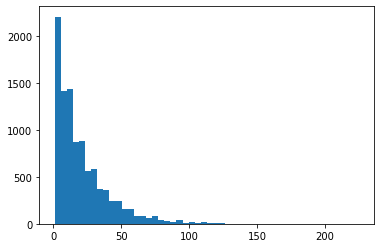

In [68]:
x = rand_event()
plt.hist(x,bins = 50)
plt.show()

## 指数分布とポアソン過程を比べる

In [69]:
# 連続した整数
y = np.arange(200)
Exp_object = ExpDistribution()

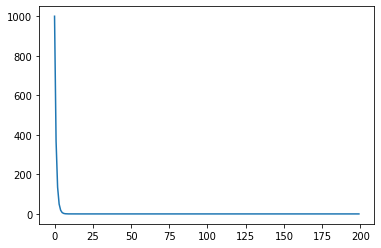

In [70]:
plt.plot(Exp_object.PDF(y)*1000)

分布は似てる、似てない？

# シミュレートしたデータに対して、指数分布をfitting

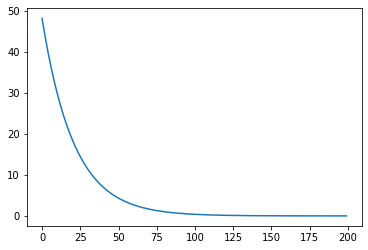

In [71]:
# パラメーターを最尤推定値で更新
Exp_object.MLEfit(x)
plt.plot(Exp_object.PDF(y)*1000)

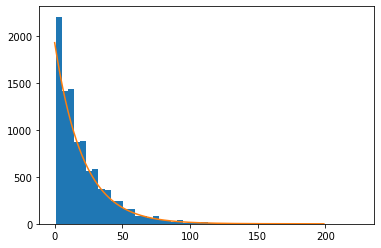

In [72]:
bins_num = 50
plt.hist(x,bins = bins_num)
plt.plot(Exp_object.PDF(y) * (bins_num-10) * 1000)
plt.show()

フィットしている

# 2.指数混合モデル

## 利点

あるイベント(ポアソン過程に従う)についての発生確率が異なる集団に対して、一つの確率分布で表現できる。<br>
イベントが発生するまでの時間に関してのデータのみが観測できたとき、そのデータを使って、クラスタを特定(ただし、確率的)できる。

## 初期状態

In [2]:
K = 2
sample_size = 100